## In this ipython notebook we will consider our method of constructing nonlinear interactions

In [74]:
import Roots
import Potapov
import Examples
import Time_Sims
import functions
import tests

import numpy as np
import numpy.linalg as la
from scipy.linalg import cholesky

import matplotlib.pyplot as plt
%matplotlib inline

In [75]:
def contour_plot(Mat):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(abs(Mat), interpolation='nearest')
    fig.colorbar(cax)
    plt.show()

In [76]:
Ex = Examples.Example3(r1 = 0.9, r3 = 0.9, max_linewidth=35.)
Ex.run_Potapov()
E = Ex.E
roots = Ex.roots
M1 = Ex.M1
delays = Ex.delays
modes = functions.spatial_modes(roots,M1,E)

In [77]:
vecs = Ex.vecs

In [78]:
roots

[(-0.35974471149047982-32.541813662957928j),
 (-0.35974471149047882+32.541813662957935j),
 (-0.36514939263783175+10.901513851604911j),
 (-0.33769377381866061+1.4264640534763705e-19j),
 (-0.36514939263783219-10.901513851604911j),
 (-0.35057287529591047+53.73045125564974j),
 (-0.346043734193046+40.605122744190666j),
 (-0.33972600185569823+20.17846799542311j),
 (-0.35057287529591047-53.73045125564973j),
 (-0.3460437341930459-40.605122744190666j),
 (-0.33972600185569823-20.17846799542311j)]

In [79]:
root_z = lambda z: 1j*z  ## a fake root we will vary

In [80]:
roots_to_use = lambda z: [root_z(z),roots[-1],roots[-2]]

In [81]:
modes_to_use = [modes[-1],modes[-1], modes[4]]

In [82]:
delay_index = 0

In [83]:
plus_or_minus_arr =  [-1,-1,-1]

In [84]:
x = np.linspace(-300,260,1000)

In [85]:
f = lambda z: functions.make_nonlinear_interaction(roots_to_use(z),modes_to_use,Ex.delays,0,0,0.1,plus_or_minus_arr)

In [86]:
### by default, indices_of_refraction=[1,1,1]

We will vary the fake root we introduced to obtain the phase-mismatch diagram. That is, the phase mismatch $\delta k$ is going to be some linear function of $z$.

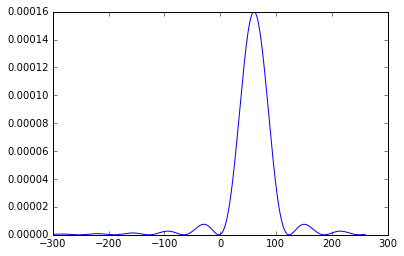

In [87]:
plt.plot(x, [abs(f(z))**2 for z in x])

What happens when we change the indices of refraction for the different modes? The phase-mismatch will shift depending on where the new $\delta k = 0$ occurs. The width of the peak may also change if the indices of refraction are large.

In [88]:
indices_of_refraction=[3.,1.1,2.]

In [89]:
f = lambda z: functions.make_nonlinear_interaction(roots_to_use(z),
                modes_to_use,Ex.delays,0,0,0.1,plus_or_minus_arr,indices_of_refraction=indices_of_refraction)

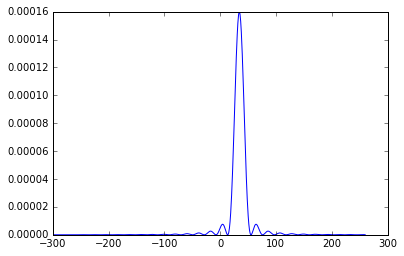

In [90]:
plt.plot(x, [abs(f(z))**2 for z in x])

# Generating a Hamiltonian from  a model

 In this section we will use example 3 to generate a Hamiltonian with nonlinaer coefficients resulting when inserting a nonlinearity in a circuit. We will assume that the nonlinearity is inserting at the delay line of index 0 corresponding to $\tau_1$.

In [91]:
import sympy as sp
import itertools
from qnet.algebra.circuit_algebra import *

In [158]:
Ex = Examples.Example3(r1 = 0.9, r3 = 0.9, max_linewidth=35.,max_freq=25.)
Ex.run_Potapov()
E = Ex.E
roots = Ex.roots
M1 = Ex.M1
delays = Ex.delays
modes = functions.spatial_modes(roots,M1,E)

In [159]:
roots

[(-0.36514939263783186-10.901513851604911j),
 (-0.33972600185569823+20.178467995423109j),
 (-0.36514939263783186+10.901513851604911j),
 (-0.33972600185569823-20.17846799542311j),
 (-0.3376937738186606-4.1474624048492497e-23j)]

In [160]:
## nonlinearity information

delay_index = 0 
start_nonlin = 0.
duration_nonlin = .1

In [161]:
len(roots)

In [162]:
len(modes)

In [163]:
m = len(roots)

In [164]:
indices = range(m)

In [165]:
chi_order = 3  ## i.e. chi-3 nonlinearity

In [166]:
plus_minus_combinations = list(itertools.combinations(range(4), 2))  ## pick which fields are annihilated

In [167]:
list_of_pm_arr = []
for tup in plus_minus_combinations:
    ls = [1]*(chi_order+1)
    for i in tup:
        ls[i]=-1
    list_of_pm_arr.append(ls)

In [168]:
list_of_pm_arr

In [169]:
a = [sp.symbols('a_'+str(i)) for i in range(m)]
a_H = [sp.symbols('a^H_'+str(i)) for i in range(m)]

In [170]:
a_ = [Destroy(local_space('fock', namespace = str(i))) for i in range(m)]

In [171]:
a_

[Destroy(LocalSpace('fock', '0')),
 Destroy(LocalSpace('fock', '1')),
 Destroy(LocalSpace('fock', '2')),
 Destroy(LocalSpace('fock', '3')),
 Destroy(LocalSpace('fock', '4'))]

In [172]:
A,B,C,D = Potapov.get_Potapov_ABCD(Ex.roots,Ex.vecs)

To obtain the SLH from the ABCD, we can use that for a passive system $\Omega = (A - A^H)/2i$. We may have to change $B$ and $C$ so that $\tilde B = \tilde C^H$ and $\tilde B \tilde C = BC$.  Also notice that $(A+A^H)/2 = BC/2$.

In [173]:
Omega = (A-A.H)/(2j)

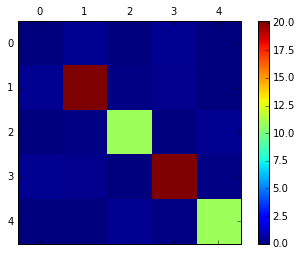

In [174]:
contour_plot(Omega)

In [175]:
## Let's look at the off-diagonal elements

Omega2 = - (A.imag+A.imag.H)/2
for i in range(Omega2.shape[0]):
    Omega2[i,i]=0

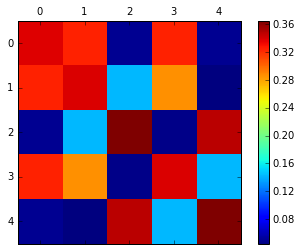

In [176]:
contour_plot((A+A.H)/2.)

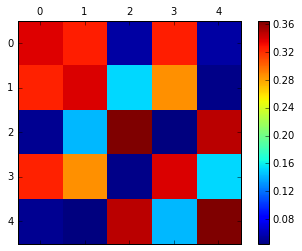

In [177]:
contour_plot(B*C/2.)

In [184]:
B*C

matrix([[-0.67538755 +0.00000000e+00j, -0.64098307 +1.21888765e-01j,
          0.00517200 +1.09698337e-01j, -0.64103169 -1.21681883e-01j,
          0.00512870 -1.09677554e-01j],
        [-0.63714873 -1.21159631e-01j, -0.67945200 +0.00000000e+00j,
         -0.02590954 +3.05554045e-01j, -0.53267495 -2.13255473e-01j,
         -0.02595059 +9.24751614e-02j],
        [ 0.00478312 -1.01450109e-01j, -0.02410560 -2.84279958e-01j,
         -0.73029879 +0.00000000e+00j, -0.02586024 +8.55278994e-02j,
         -0.68339928 -1.38881699e-01j],
        [-0.63719707 +1.20953986e-01j, -0.53267495 +2.13255473e-01j,
         -0.02779549 -9.19283786e-02j, -0.67945200 +0.00000000e+00j,
         -0.02783656 -3.05384875e-01j],
        [ 0.00474308 +1.01430888e-01j, -0.02414379 -8.60366126e-02j,
         -0.68339928 +1.38881699e-01j, -0.02589845 +2.84122566e-01j,
         -0.73029879 -1.38777878e-17j]])

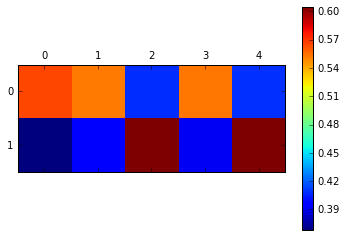

In [190]:
contour_plot(C)

In [185]:
A+A.H

matrix([[-0.67538755+0.j        , -0.63714873+0.12115963j,
          0.00478312+0.10145011j, -0.63719707-0.12095399j,
          0.00474308-0.10143089j],
        [-0.63714873-0.12115963j, -0.67945200+0.j        ,
         -0.02410560+0.28427996j, -0.53267495-0.21325547j,
         -0.02414379+0.08603661j],
        [ 0.00478312-0.10145011j, -0.02410560-0.28427996j,
         -0.73029879+0.j        , -0.02779549+0.09192838j,
         -0.68339928-0.1388817j ],
        [-0.63719707+0.12095399j, -0.53267495+0.21325547j,
         -0.02779549-0.09192838j, -0.67945200+0.j        ,
         -0.02589845-0.28412257j],
        [ 0.00474308+0.10143089j, -0.02414379-0.08603661j,
         -0.68339928+0.1388817j , -0.02589845+0.28412257j, -0.73029879+0.j        ]])

In [183]:
la.eig(-(A+A.H)/2.)

(array([  9.77991736e-01 +9.86372279e-18j,
          7.64052897e-01 +4.77052440e-18j,
         -1.28007009e-04 +3.41058100e-17j,
          1.78656417e-03 +3.38029892e-18j,   3.74137277e-03 +1.42328169e-17j]),
 matrix([[  5.86940305e-01+0.j        ,  -1.66482196e-03-0.00421112j,
            6.20002043e-02+0.46269419j,   6.58688903e-01+0.j        ,
           -5.53549769e-02-0.024807j  ],
         [  5.55122131e-01+0.10534925j,   9.15694921e-03-0.18421081j,
           -2.72682838e-02+0.14909218j,  -6.39032137e-01-0.12456245j,
           -4.20303507e-01-0.15237629j],
         [ -2.54255160e-03+0.08372433j,   6.84391508e-01+0.j        ,
            5.91804487e-01+0.j        ,  -5.48350795e-02+0.3118593j ,
            7.94764757e-02-0.26034567j],
         [  5.56498492e-01-0.1053536j ,   4.53016352e-02+0.17317519j,
           -1.38838305e-01-0.45742393j,  -1.06658988e-01+0.01552745j,
            6.37995453e-01+0.j        ],
         [ -3.32526634e-03-0.09178668j,   6.69008412e-01-0.13400055

In [182]:
B_tilde = np.asmatrix(cholesky(-B*C,overwrite_a=True))
C_tilde = B_tilde.H

LinAlgError: 5-th leading minor not positive definite

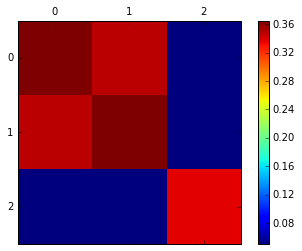

In [179]:
contour_plot(C_tilde*C_tilde.H/2.)

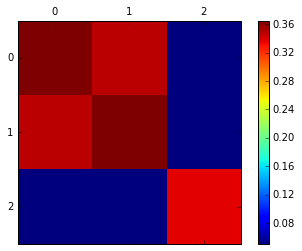

In [114]:
contour_plot(B_tilde.H*B_tilde/2.)

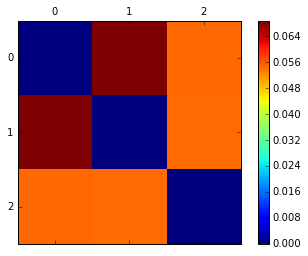

<function matplotlib.pyplot.show>

In [115]:
#what is left in Omega after subtracting the diagonal
contour_plot(Omega2)
plt.show

## Next, we will make the assumption that the off-diagonal elements are zero. More generally, we can diagonalize the Hamiltonian. However, the modes are not exactly orthogonal; the error introduced by this is of the same order as no diagonalizing the Hamiltonian above.

In [116]:
H_lin_sp = sum([a_H[i]*a[i]*Omega[i,i] for i in range(m)])  ## with sympy only

In [117]:
H_lin = sum([a_[i].dag()*a_[i]*Omega[i,i] for i in range(m)])  ## with QNET

In [118]:
H_lin

OperatorPlus(ScalarTimesOperator((10.901513851604907+0j), OperatorTimes(Create(LocalSpace('fock', '0')), Destroy(LocalSpace('fock', '0')))), ScalarTimesOperator((-10.901513851604912-0j), OperatorTimes(Create(LocalSpace('fock', '1')), Destroy(LocalSpace('fock', '1')))), ScalarTimesOperator((-9.6224584680117385e-20-0j), OperatorTimes(Create(LocalSpace('fock', '2')), Destroy(LocalSpace('fock', '2')))))

In [119]:
def make_nonlin_term_sp(combination,pm_arr):
    '''
    Make symbolic term
    With sympy only
    '''
    r = 1
    for index,sign in zip(combination,pm_arr):
        if sign == 1:
            r*= a_H[index]
        else:
            r *= a[index]
    return r

In [120]:
def make_nonlin_term(combination,pm_arr):
    '''
    Make symbolic term
    With QNET
    '''
    r = 1
    for index,sign in zip(combination,pm_arr):
        if sign == 1:
            r*= a_[index].dag()
        else:
            r *= a_[index]
    return r

In [134]:
H_lin_sp

Let's impose a large 'index of refraction'. In the future we will replaces this by better conditions for phase-mismatch, including realistic values. For now, this will narrow the gain versus $\Delta k$ function so that few interaction terms remain.

In [121]:
def weight(combination,pm_arr):
    roots_to_use = np.array([roots[i] for i in combination])
    modes_to_use = [modes[i] for i in combination]
    return functions.make_nonlinear_interaction(roots_to_use, modes_to_use, delays, delay_index,
                                start_nonlin,duration_nonlin,pm_arr,
                                indices_of_refraction = [1000.]*len(combination),
                                eps=1e-12,func=lambda z : z.imag)

In [122]:
## TODO: add a priori check to restrict exponential growth
weights = {}

In [123]:

count = 0

for pm_arr in list_of_pm_arr:
    field_combinations = itertools.combinations_with_replacement(range(m), chi_order+1)
    for combination in field_combinations:
        count += 1
        weights[tuple(combination),tuple(pm_arr)] = weight(combination,pm_arr)        
print count

90


(array([ 58.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  16.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         10.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          6.]), array([  3.92408486e-08,   1.15799812e-04,   2.31560382e-04,
          3.47320953e-04,   4.63081524e-04,   5.78842094e-04,
          6.94602665e-04,   8.10363236e-04,   9.26123807e-04,
          1.04188438e-03,   1.15764495e-03,   1.27340552e-03,
          1.38916609e-03,   1.50492666e-03,   1.62068723e-03,
         

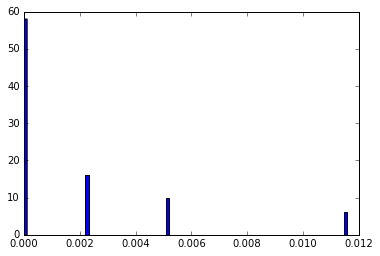

In [124]:
plt.hist([abs(x) for x in [weights[key] for key in weights] ],bins=100)

As we see above, most of the interactions are negligible. Let's drop them out.

In [125]:
significant_weight_keys = [key for key in weights if abs(weights[key]) > 1e-4]

In [126]:
significant_weights = dict((key,weights[key]) for key in significant_weight_keys)

In [127]:
len(significant_weights)

In [128]:
'''H_nonlin_sp = 0  ## with sympy only

for combination,pm_arr in significant_weights:
    H_nonlin_sp += make_nonlin_term_sp(combination,pm_arr)*significant_weights[combination,pm_arr]'''

'H_nonlin_sp = 0  ## with sympy only\n\nfor combination,pm_arr in significant_weights:\n    H_nonlin_sp += make_nonlin_term_sp(combination,pm_arr)*significant_weights[combination,pm_arr]'

In [129]:
H_nonlin = 0  ## with QNET

for combination,pm_arr in significant_weights:
    H_nonlin += make_nonlin_term(combination,pm_arr)*significant_weights[combination,pm_arr]

In [130]:
H_nonlin

OperatorPlus(ScalarTimesOperator((0.01157609631319622+0j), OperatorTimes(Create(LocalSpace('fock', '0')), Create(LocalSpace('fock', '0')), Destroy(LocalSpace('fock', '0')), Destroy(LocalSpace('fock', '0')))), ScalarTimesOperator((0.0051419161593478646-4.5102810375396986e-18j), OperatorTimes(Create(LocalSpace('fock', '0')), Create(LocalSpace('fock', '0')), Destroy(LocalSpace('fock', '1')), Destroy(LocalSpace('fock', '2')))), ScalarTimesOperator((0.0051419161593478663-3.4694469519536144e-19j), OperatorTimes(Create(LocalSpace('fock', '0')), Destroy(LocalSpace('fock', '0')), Create(LocalSpace('fock', '1')), Destroy(LocalSpace('fock', '1')))), ScalarTimesOperator((0.0051419161593478611+0j), OperatorTimes(Create(LocalSpace('fock', '0')), Destroy(LocalSpace('fock', '0')), Create(LocalSpace('fock', '2')), Destroy(LocalSpace('fock', '2')))), ScalarTimesOperator((0.01157609631319622+0j), OperatorTimes(Create(LocalSpace('fock', '0')), Destroy(LocalSpace('fock', '0')), OperatorPlus(IdentityOperato

### Using the symbolic packages is kind of slow. For classical simulations maybe we can avoid that. We just need to extract the equations of motion, which should end up being sparse in the interaction terms 

In [131]:
## consolidated weights do not take into account which modes are createad or annihilated.

'''
consolidated_weightes = {}
for key in significant_weights:
    if not key[0] in consolidated_weightes:
        consolidated_weightes[key[0]] = significant_weights[key]
    else:
        consolidated_weightes[key[0]] += significant_weights[key]
'''

'\nconsolidated_weightes = {}\nfor key in significant_weights:\n    if not key[0] in consolidated_weightes:\n        consolidated_weightes[key[0]] = significant_weights[key]\n    else:\n        consolidated_weightes[key[0]] += significant_weights[key]\n'

In [132]:
'''len(consolidated_weightes)'''

'len(consolidated_weightes)'